<a href="https://colab.research.google.com/github/manikeerthana/CVV/blob/main/ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mount Drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


##Required Imports


In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

In [ ]:
# More information about dataset can be found here http://www.vision.caltech.edu/visipedia/CUB-200.html
data_dir = "/content/drive/My Drive/TF3 C3 W1 Data/"

##Visualization Utilities

In [ ]:
# Draws Single Bounding box on an Image

def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    (xmin , ymin) ---> top left corner 
    (xmax , ymax) ---> bottom right corner
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


In [ ]:

# Draw multiple bounding boxes on an Image

def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.
    
    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
                           
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


In [ ]:
# Main Utility function which invokes above two methods

def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).
    
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image

## Data and Prediction Utilities

In [ ]:
#Matplotlib runt time configuration( rc)
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
print(MATPLOTLIB_FONT_DIR)

/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf


In [ ]:
# To display objects with boxes in a row 

def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)

In [ ]:
# display training and validation metrics

def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Loading the Dataset


In [ ]:
# Below function 
# i) Resizes image to ( 224 , 224)
# ii) Normalizes image
# It returns normalized image and bounding box

def read_image_tfds(image, bbox):

    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)
    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
    return image, bbox_list


In [ ]:
# This function keeps a copy of original image and preprocess other image 4
# It returns Image and bounding box

def read_image_with_shape(image, bbox):
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list

In [ ]:
# This funtion reads image from data 
# This denormalizes the bounding boxes
# It returns original image and bounding box 

def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)

   
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y =  tf.cast(shape[0], tf.float32)
  
    
    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]

    
    return image, bbox_list

In [ ]:
# This funtion converts dataset in to numpy arrays of images and boxes
# This will take dataset and returns ( images , bounding boxes)

def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

In [ ]:
# This function converts dataset into numpy arrays -- 
#  i) Original images
#  ii) resized and normalized images
#  iii) bounding boxes
#  It returns batch of original images, normalzed images and normalized bounding boxes

def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)


## Visualize images and their bounding boxes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


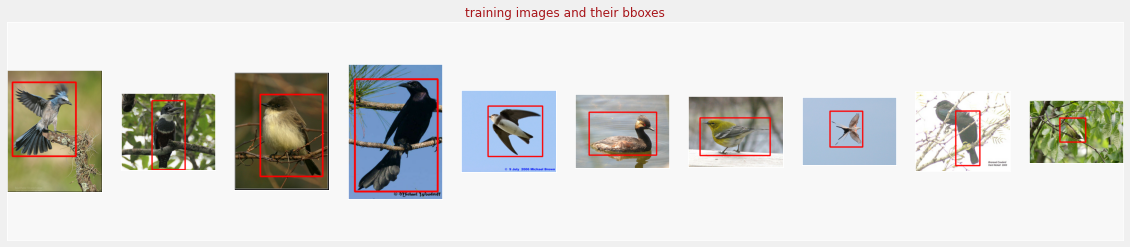

In [ ]:
# This funtion loads dataset and maps it to ( read_image_tfds_with_original_bbox ) 
# to get images, bounding boxes.
# Then they were converted into numpy arrays

def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=False)
    # print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, 
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


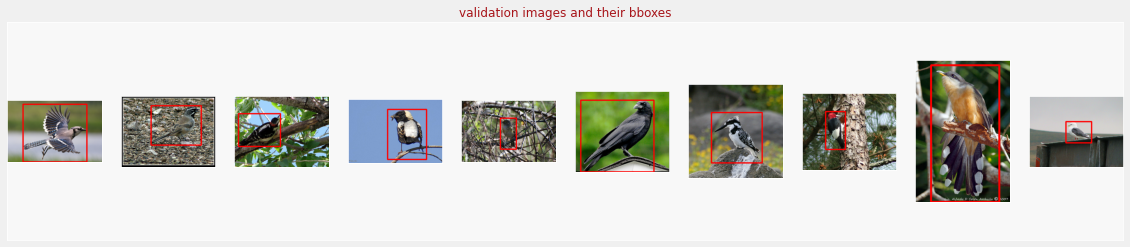

In [ ]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", data_dir=data_dir, download=False)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

## Loading and Preparing dataset for the model

In [ ]:
BATCH_SIZE = 64

# Preparing training and validation dataset 
# Pipeline of functions :
# get_visualization_training_dataset ( read_image_tfds_with_original_bbox )
# ---- > get_training_dataset ( read_image_tfds ) ---> Our Train Data

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

## Model Creation 

In [ ]:
# bounding box is regression task
# Performing transfer learning with MobileNet V2
# We will use pretrained ( ImageNet) weights 
# his acts as feature extractor of the images

def feature_extractor(inputs) :
    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(input_shape= [224,224,3], include_top=False, weights= 'imagenet')
    
    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)
            
    # return the feature_extractor
    return feature_extractor




In [ ]:
# Our own dense layers attached to the feature extractors

def dense_layers(features):
    

    # global average pooling 2D layer.
    x = tf.keras.layers.GlobalAveragePooling2D()(features) 
    
    # flatten layer
    x = tf.keras.layers.Flatten()(x) 
    
    # 1024 Dense layer, with relu
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    
    # 512 Dense layer, with relu
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    
    
    return x

In [ ]:
# Bounding box prediction network path 


def bounding_box_regression(x):
    
    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(4, name = 'bounding_box')(x) 


    return bounding_box_regression_output


In [ ]:
## Combine all the above defined funtions

def final_model(inputs):
    # features
    feature_cnn = feature_extractor(inputs) 

    # dense layers
    last_dense_layer = dense_layers(feature_cnn) 

    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer)
    
    # define the TensorFlow Keras model using the inputs and outputs to your model
    model = tf.keras.models.Model(inputs = inputs, outputs = bounding_box_output)

    return model

## Compile the Model

In [ ]:
def define_and_compile_model():
  
    # define the input layer
    inputs = tf.keras.layers.Input(shape = (224, 224,3))
    
    # create the model
    model = final_model(inputs) 
    
    # compile your model 
    model.compile(optimizer= tf.keras.optimizers.SGD(momentum=0.9) , loss = 'mse' )    

    return model

In [ ]:
# define your model
model = define_and_compile_model()
# print model layers
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
bounding_box (Dense)         (None, 4)                 2052  

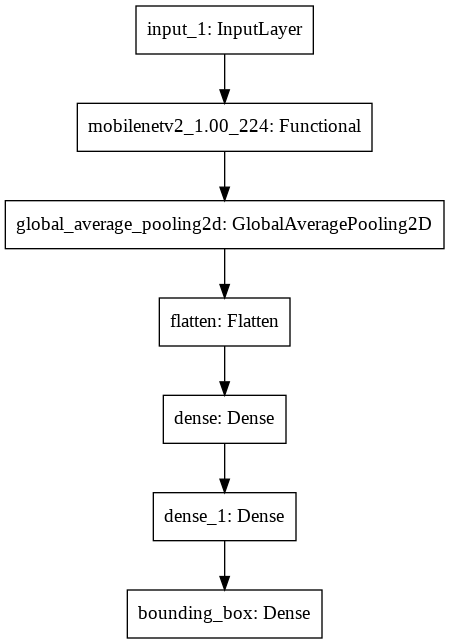

In [ ]:
tf.keras.utils.plot_model(model)

## Training the model 

In [ ]:
# we will do it for short duration of time
EPOCHS = 50

# Choose a batch size
BATCH_SIZE = 64

# Get the length of the training set
length_of_training_dataset = len(visualization_training_dataset) 
print(length_of_training_dataset)

# Get the length of the validation set
length_of_validation_dataset = len(visualization_validation_dataset) 
print(length_of_validation_dataset)

# Get the steps per epoch (may be a few lines of code)
steps_per_epoch = length_of_training_dataset // BATCH_SIZE 
if length_of_training_dataset % BATCH_SIZE > 0:
    steps_per_epoch += 1 

print(steps_per_epoch)

# get the validation steps (per epoch) (may be a few lines of code)
validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1
    
print(validation_steps)

3000
3033
47
48


In [ ]:
history = model.fit(training_dataset , 
                    steps_per_epoch= steps_per_epoch,
                    validation_data=validation_dataset, 
                    validation_steps = validation_steps, 
                    epochs = EPOCHS)

Epoch 1/50
47/47 [==============================] - 60s 1s/step - loss: 0.1121 - val_loss: 0.3763
Epoch 2/50
47/47 [==============================] - 49s 1s/step - loss: 0.0177 - val_loss: 0.2963
Epoch 3/50
47/47 [==============================] - 48s 1s/step - loss: 0.0131 - val_loss: 0.2090
Epoch 4/50
47/47 [==============================] - 48s 1s/step - loss: 0.0104 - val_loss: 0.1876
Epoch 5/50
47/47 [==============================] - 54s 1s/step - loss: 0.0086 - val_loss: 0.1307
Epoch 6/50
47/47 [==============================] - 49s 1s/step - loss: 0.0076 - val_loss: 0.1169
Epoch 7/50
47/47 [==============================] - 48s 1s/step - loss: 0.0066 - val_loss: 0.1036
Epoch 8/50
47/47 [==============================] - 48s 1s/step - loss: 0.0057 - val_loss: 0.0833
Epoch 9/50
47/47 [==============================] - 54s 1s/step - loss: 0.0052 - val_loss: 0.0723
Epoch 10/50
47/47 [==============================] - 48s 1s/step - loss: 0.0049 - val_loss: 0.0608
Epoch 11/50
47/47 [

## Validate Model 

In [ ]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

48/48 [==============================] - 15s 306ms/step - loss: 0.0163
Loss:  0.01628056913614273


## Plot Loss function

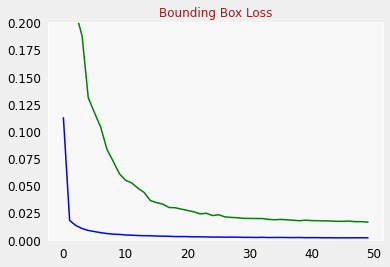

In [ ]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

## Evaluate performance using IOU

In [ ]:
def intersection_over_union(pred_box, true_box):
    
    print(pred_box.shape)
    print(pred_box)
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)
    
    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(500, 4)
[[0.06300002 0.16821459 0.82437104 0.9046493 ]
 [0.21815383 0.3485598  0.70171785 0.6563003 ]
 [0.26433128 0.30664915 0.6141055  0.66877866]
 ...
 [0.26994067 0.36647367 0.8103335  0.77081585]
 [0.4273203  0.21795085 0.8328156  1.0064151 ]
 [0.12883878 0.12674132 0.8610894  0.97747356]]
Number of predictions where iou > threshold(0.5): 250
Number of predictions where iou < threshold(0.5): 250


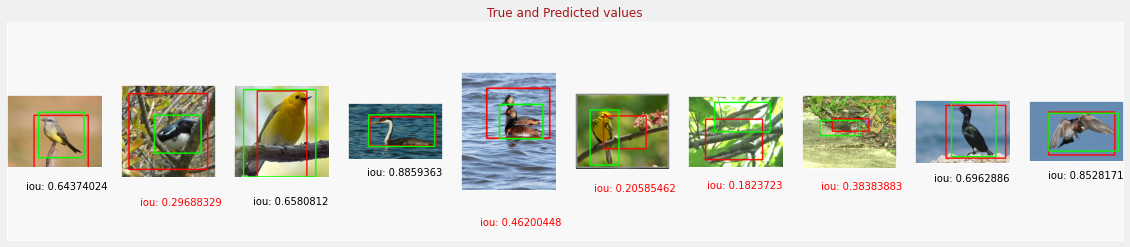

In [ ]:

n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)